## SPOTIFY GENRE PREDICTION - CLASSIFICATION 
### Useful imports

Below are the imports that were useful in the cleaning and pre-processing, classification as well as the visualization methods. 

In [24]:
###IMPORTS
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

### Pre-processing and cleaning

We started the cleaning the data by dropping the unneccesary columns reduce the dimensions of the dataset. The columns that were dropped didn't contribute to any improvements in regards of the classification problem so we decided to drop them. We started by converting the strings to floats by encoding them, but we then decided to drop them anyways since they didn't contribute to the algorithm. We also noticed some inconsistincies, for example some values were just missing, others conained questionmarks (?) and others said 'NaN'. We decided to replace all of the missing values with 'NaN' so it would be easier to remove all of them later. 

Furthermore, we replaced the mode (Minor/Major) with the float values 0.0 and 1.0, so that all of the feature data is stored as the same type (float64). We also realised that there are five rows that only contain NaN values, so we removed those as well. 

Lastly we noticed that the column 'tempo' for some reason contained lots of missing values, so we dropped that as well. 

In [31]:
data = pd.read_csv('music_dataset.csv', header='infer')

#Drop unnecessary columns
columns_drop = ['instance_id', 'track_name', 'key', 'obtained_date', 'artist_name']  # popularity #duration_ms
rows_drop = ['Rap', 'Alternative']

# Drop rows based on conditions
data = data[~data['music_genre'].isin(rows_drop)]
data = data.drop(columns=columns_drop)
print(data.head(10))

#Replace '?' with NaN
data = data.applymap(lambda cell: np.NaN if str(cell) == "?" else cell)

#Replace missing values with NaN
data = data.fillna(np.NaN)

#Replace mode with binary numbers
data['mode'] = data['mode'].replace({'Minor': 0.0, 'Major': 1.0})

#Count missing values for every column in our dataset
NaN_values = data.isna().sum()
print("Missing values per column:")
print(NaN_values)

NaN_rows = data[data.isna().all(axis=1)]    #Check to see if they are all on the same row
print(NaN_rows)             

data = data.dropna(how='all')           #Drop rows with all NaN values

data = data.drop(columns='tempo')       #Lots of missing values, drop this column

   popularity  acousticness  danceability  duration_ms  energy  \
0        27.0       0.00468         0.652         -1.0   0.941   
1        31.0       0.01270         0.622     218293.0   0.890   
2        28.0       0.00306         0.620     215613.0   0.755   
3        34.0       0.02540         0.774     166875.0   0.700   
4        32.0       0.00465         0.638     222369.0   0.587   
5        47.0       0.00523         0.755     519468.0   0.731   
6        46.0       0.02890         0.572     214408.0   0.803   
7        43.0       0.02970         0.809     416132.0   0.706   
8        39.0       0.00299         0.509     292800.0   0.921   
9        22.0       0.00934         0.578     204800.0   0.731   

   instrumentalness  liveness  loudness   mode  speechiness  \
0          0.792000    0.1150    -5.201  Minor       0.0748   
1          0.950000    0.1240    -7.043  Minor       0.0300   
2          0.011800    0.5340    -4.617  Major       0.0345   
3          0.002530  

### Handling outliers
We mapped out the outliers by visualizing with boxplots for each feature. Thereafter we removed all of the outliers by setting the threshold for the z-score to 3 (meaning three standard deviations from the mean). 

In [26]:
#BOXPLOTS TO SEE OUTLIERS ETC..
# numerical_columns = data.select_dtypes(include=['float64']).columns

# plt.figure(figsize=(15, 10))
# num_numerical_columns = len(numerical_columns)
# num_rows = (num_numerical_columns + 1) // 2  #Number of rows needed

# for i, column in enumerate(numerical_columns, start=1):
#     plt.subplot(num_rows, 2, i)
#     sns.boxplot(x=data[column].values)
#     plt.title(f'Boxplot of {column}')

# plt.tight_layout()
# plt.show()


#OUTLIERS
numerical_columns = data.select_dtypes(include=['float64']).columns

#Calculate Z-scores for each numerical column
z_scores = np.abs(stats.zscore(data[numerical_columns]))

threshold = 3

#Find and remove rows with outliers
data_no_outliers = data[(z_scores < threshold).all(axis=1)]

# Print the shape before and after removing outliers
print("\n")
print("Size of dataset before removing outliers:", data.shape)
print("Size of dataset after removing outliers:", data_no_outliers.shape)




Size of dataset before removing outliers: (40000, 12)
Size of dataset after removing outliers: (36680, 12)


### Normalization of the data
Even though Random Forest classification algorithms aren't sensitive to normalization issues, we still decided to normalize the data with the MinMax scaling method here. We used normalization in our clustering and frequent pattern mining algoritmhs and we wanted to keep our pre-proccesing as consistent as possible throughout our work. The output below shows the first 10 rows of data after using the MinMax normalization.  

In [27]:
#NORMALIZATION
#Extract numerical columns for normalization
numerical_columns = data.select_dtypes(include=['float64']).columns

scaler = MinMaxScaler()

#Fit and transform the numerical columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

data = data.reset_index(drop=True)
print(data.head(10))        #Print first 10 rows


   popularity  acousticness  danceability  duration_ms    energy  \
0    0.281250      0.004699      0.639465     0.000000  0.941896   
1    0.322917      0.012751      0.607081     0.045190  0.890804   
2    0.291667      0.003072      0.604922     0.044635  0.755562   
3    0.354167      0.025502      0.771157     0.034546  0.700463   
4    0.333333      0.004669      0.624352     0.046034  0.587260   
5    0.489583      0.005251      0.750648     0.107537  0.731519   
6    0.479167      0.029016      0.553109     0.044386  0.803648   
7    0.447917      0.029819      0.808938     0.086145  0.706474   
8    0.406250      0.003002      0.485104     0.060614  0.921860   
9    0.229167      0.009378      0.559585     0.042397  0.731519   

   instrumentalness  liveness  loudness  mode  speechiness   valence  \
0          0.795181  0.106358  0.823883   0.0     0.057084  0.765121   
1          0.953815  0.115446  0.787616   0.0     0.008372  0.535282   
2          0.011847  0.529450  0.83

### Classification
For our classification algorithm we have our features stored as X, which is created by dropping the 'music_genre' column (the target variable). 
Y is set as the 'music_genre' column, representing the target variable, so-called class labels. We also checked for any potential class imbalance and calculated the sizes for each class. We noticed that all of the genres (classes) are luckily of the same size, which means that we didn't need to apply any class weightning. 

We continued by splitting the data into 80% training data and 20% validation data. We then used the RandomForestClassifie on the data. We experimented a little bit with the hyperparameters, and realised that the ones used below give the highest accuracy. The number of trees in the forest is set to 100. Based on the clf model we made predictions for the test validation set. Lastly we printed out the accuracy of score for each class, which was very interesting to look at. 

Cross-validation is performed using cross_val_score to observe the model's performance across multiple folds of the dataset, and we saw that the accuracy for cross-validation was the same as before which indicates that we likely don't have problems with overfitting. 

The confusion matrix is printed to analyize potential false predicitions and see how the model is performing (regarding positive/negative predictions). 


In [28]:
###CLASSIFICATION
#Separate features and target variable (class)
X = data.drop(columns=['music_genre'])  #Drop 'music_genre' and the original 'artist_name' (now encoded)
Y = data['music_genre']     #class

#Check for imbalanced classes
class_distribution = data['music_genre'].value_counts()
print("Class Distribution:\n", class_distribution)

#Calculate class weights
class_weights = dict(1 / class_distribution)

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#RANDOM FOREST CLASSIFIER
clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, class_weight=class_weights)

#Train the classifier
clf.fit(X_train, Y_train)

#Make predictions on the test set
Y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Cross-validation
scores = cross_val_score(clf, X, Y, cv=5)
print(f"Cross-validated accuracy: {np.mean(scores):.2f}")

# Print statements
print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Class Distribution:
 Electronic    5000
Anime         5000
Jazz          5000
Country       5000
Blues         5000
Rock          5000
Classical     5000
Hip-Hop       5000
Name: music_genre, dtype: int64
Cross-validated accuracy: 0.69
Accuracy: 0.69
Confusion Matrix:
[[730  80  72  51  57   1  19  11]
 [ 85 516  12 126  74   7 104  70]
 [ 37  38 826  13  25   1  44   8]
 [ 24  53   0 569  14  23  45 236]
 [ 60  88   5  43 610  38 128  54]
 [  1   2   0  13  14 885   8  85]
 [ 17 102  60  99 150  23 500  52]
 [  6   3   1  27   7  68  27 853]]


### Feature importance
With the help of pandas library we printed out the importances for the features that we used. We realised that popularity is the most important feature, which is interesting because we initially dropped that column because we thought that it didn't matter for the class - but it turned out that it really did. 

In [29]:
#FEATURE IMPORTANCE
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': clf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)


             Feature  Importance
0         popularity    0.292255
7           loudness    0.130294
9        speechiness    0.111551
5   instrumentalness    0.108153
2       danceability    0.099667
1       acousticness    0.087021
4             energy    0.075020
10           valence    0.043875
3        duration_ms    0.029255
6           liveness    0.012184
8               mode    0.010726


### Visualization of data
Down below we show howe we visualized our data and algorithm.  

Correlation heatmap: This is computed using the corr() function on the dataset. The matrix represents the pairwise correlation coefficients between numerical features. We had some features that had a strong positive/negative correlation, but also lots of features that don't seem to correlate at all.

Distribution of Target Classes: A bar plot is used to illustrate the distribution of target classes, 'music_genre', using Matplotlib and Pandas.
As we can see we don't have any class weightning problem, all of the classes are actually of the same size (5000 values). 

Confusion Matrix: This is used to evaluate the performance of a classification model. It gives a breakdown of how well a model is doing in terms of making predictions on a set of data points.

Feature Importance Chart: The feature importance scores obtained from the Random Forest classifier are visualized as a horizontal bar plot. Seaborn (sns.barplot) is used to create the plot, with the x-axis representing the importance scores and the y-axis representing the feature names.

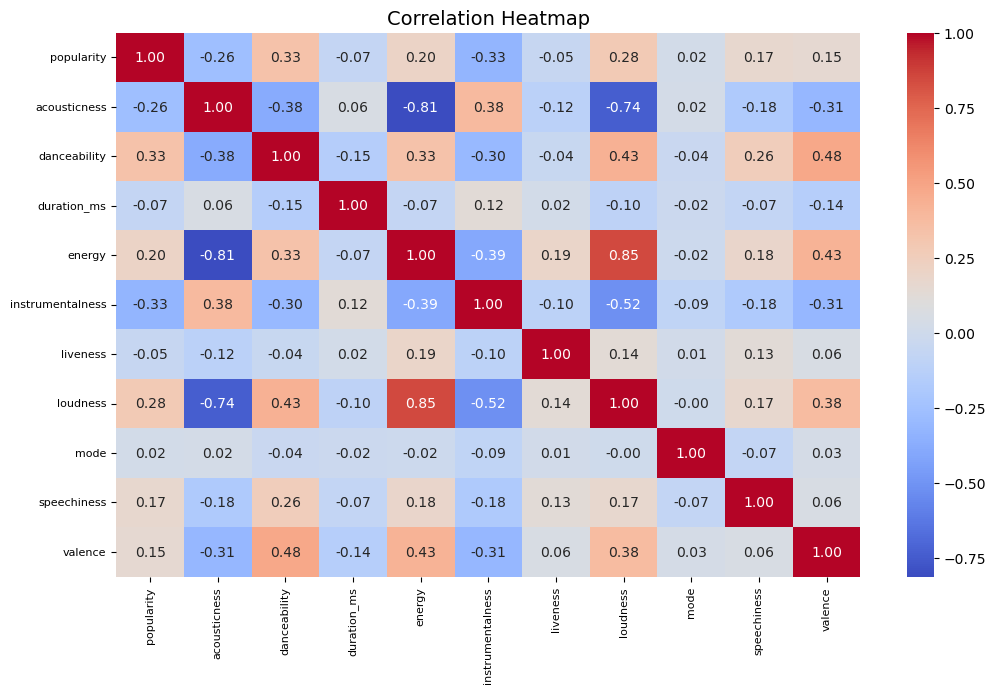

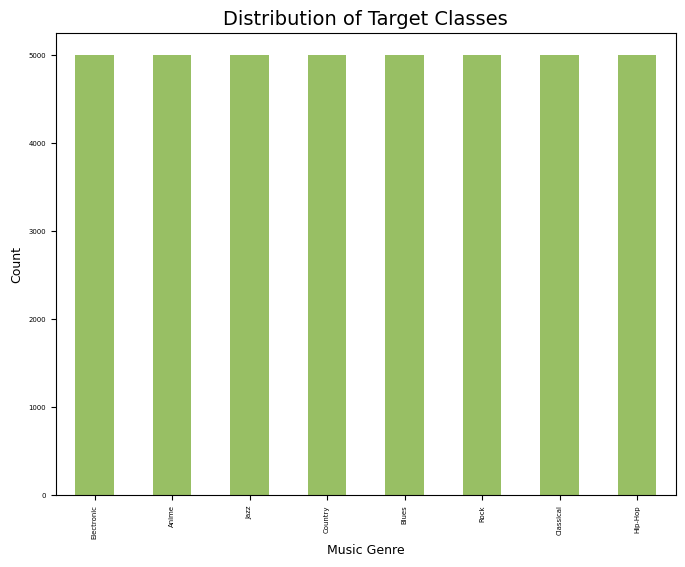

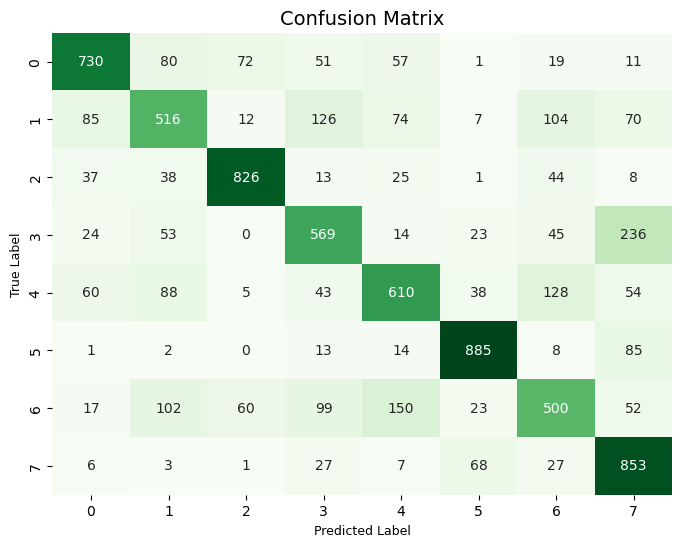

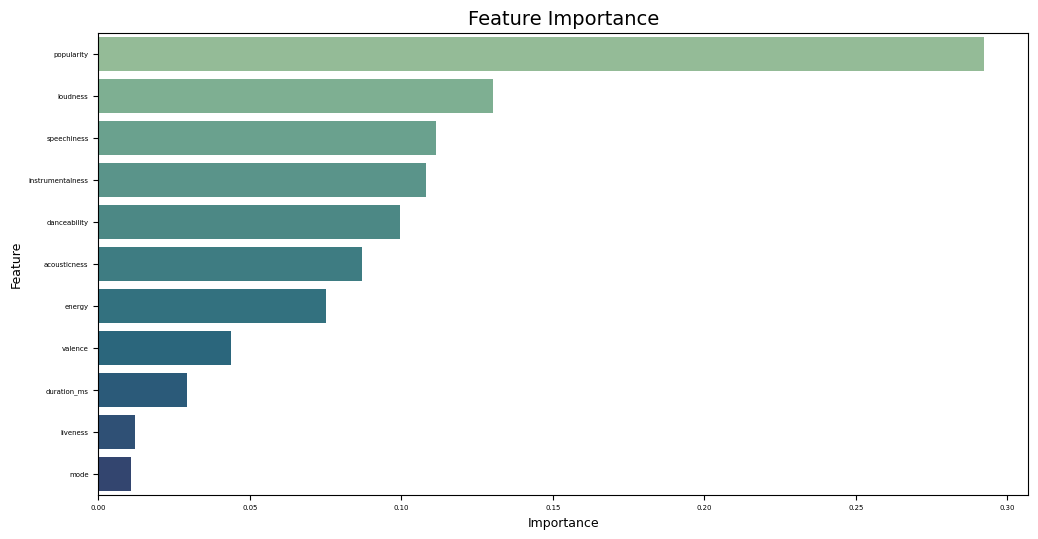

In [30]:
###VISUALIZATION

#CORRELATION MATRIX
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.subplots_adjust(bottom=0.2)
plt.title("Correlation Heatmap", fontsize=14)
plt.xticks(fontsize=8) 
plt.yticks(fontsize=8)  
plt.show()

#TARGET CLASSES, DISTRIBUTION
plt.figure(figsize=(8, 6))
data['music_genre'].value_counts().plot(kind='bar', color="#98BF64")
plt.title("Distribution of Target Classes", fontsize=14)
plt.xticks(fontsize=5) 
plt.yticks(fontsize=5)  
plt.xlabel("Music Genre", fontsize=9)
plt.ylabel("Count", fontsize=9)
plt.show()

# CONFUSION MATRIX
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d", cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=9) 
plt.ylabel("True Label", fontsize=9)
plt.show()

# FEATURE IMPORTANCE
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="crest")
plt.title("Feature Importance", fontsize=14)
plt.xticks(fontsize=5) 
plt.yticks(fontsize=5)  
plt.xlabel("Importance", fontsize=9)  
plt.ylabel("Feature", fontsize=9) 
plt.show()